전체 문항은 16문항 기준</br>
input은 유저가 고른 답변의 문항 번호 list</br>
output은 top-k 취미

In [ ]:
from keras.datasets import reuters
from tensorflow import keras
import numpy as np
from keras.utils.np_utils import to_categorical
from keras import models
from keras import layers
import matplotlib.pyplot as plt

# 데이터 전처리

In [ ]:
# train data 형식

answers = [[1,2,4,1,2,3,3,2,1,2,3,1,1,2,3,2],
           [2,3,4,1,2,2,3,1,3,1,3,2,2,1,1,1],
           [1,1,4,3,2,1,3,2,3,1,3,2,1,2,2,1],
           [2,1,4,1,2,3,3,1,3,2,1,1,1,1,1,1],
           [2,3,2,3,1,2,2,1,1,2,3,1,1,1,2,2]]

X_labels = np.array([1,2,3,4,0])

num2hobby = {1:'취미1',
             2:'취미2',
             3:'취미3',
             4:'취미4',
             0:'취미5'}

# 예측용 data

pred_data = [[1,2,4,1,2,3,2,2,1,2,3,1,1,2,3,2],
           [2,3,4,1,2,2,3,1,3,1,3,2,2,1,1,1],
           [1,1,4,3,2,1,3,2,3,1,3,2,1,1,2,1],
           [2,1,4,1,2,3,3,1,1,2,1,1,1,1,1,1],
           [2,3,2,3,1,2,2,1,1,2,2,1,1,1,2,2]]

In [ ]:
# 문항 개수에 따른 accumulative bias 생성, 리스트의 값은 각 문항별 전체 답변 개수!

num_per_question = [2,3,4,3,2,3,3,2,3,2,3,2,2,2,2,2]
question_bias = []
for idx, num in enumerate(num_per_question):
  if idx==0: question_bias.append(0)
  else:
    question_bias.append(sum(num_per_question[:idx]))

In [ ]:
# 답안 + accumulative bias

answers_with_bias = []
for answer in answers:
    answer_to_data = [(a+b-1) for a, b in zip(answer, question_bias)]
    answers_with_bias.append(answer_to_data)

preds_with_bias = []
for pred in pred_data:
    pred_to_data = [(a+b-1) for a, b in zip(pred, question_bias)]
    preds_with_bias.append(pred_to_data)

### 각 문항 개수에 따른 accumulative bias를 사용하는 이유

답변을 벡터화 시켜서 input으로 주기 때문!</br> 
accumulative bias를 각 답변에 더해준 후에 vectorize하면, </br>
input vector에 positional information도 들어가는 셈</br> 
=> "몇번 문항에 몇번 답변을 골랐다" 라는 정보가 입력되는 꼴

In [ ]:
def vectorize_sequences(sequences, dimension=40):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        sequence = list(sequence)
        results[i, sequence] = 1.
    return results

In [ ]:
# sequential data vectorize

X_train = vectorize_sequences(answers_with_bias)
X_test = vectorize_sequences(preds_with_bias)

In [ ]:
# one hot encoding

one_hot_train_labels = to_categorical(X_labels)

### one hot encoding을 사용하는 이유

각 label들은 연속성이나 순서에 대한 의미가 없기 때문에 one hot vector를 사용하는 것이 학습과 추론에 용이하다!

# 학습

In [ ]:
# 새 모델로 시작

model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(40,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train

history = model.fit(X_train,
                    one_hot_train_labels,
                    epochs=20,
                    batch_size=512
                    )

Epoch 1/20
1/1 [==============================] - 0s 10ms/step - loss: 1.1237 - accuracy: 1.0000
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 1.1008 - accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 0s 6ms/step - loss: 1.0774 - accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 0s 9ms/step - loss: 1.0537 - accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 0s 7ms/step - loss: 1.0304 - accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 12ms/step - loss: 1.0083 - accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.9875 - accuracy: 1.0000
Epoch 8/20
1/1 [==============================] - 0s 9ms/step - loss: 0.9674 - accuracy: 1.0000
Epoch 9/20
1/1 [==============================] - 0s 8ms/step - loss: 0.9477 - accuracy: 1.0000
Epoch 10/20
1/1 [==============================] - 0s 23ms/step - loss: 0.9282 - accuracy: 1.0000
Epoch 11/20
1/1 [===================

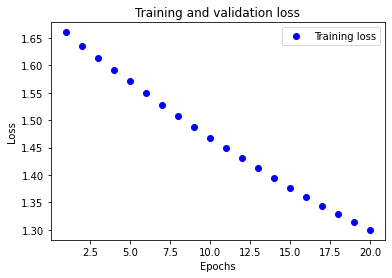

In [ ]:
# Loss 시각화

loss = history.history['loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# 결과 예측

predictions = model.predict(X_test)

1/1 [==============================] - 0s 58ms/step


In [ ]:
# 모델 저장

model.save('./model_saved')

# 추론

In [ ]:
# 저장된 모델 로드

model = keras.models.load_model('./model_saved')

In [ ]:
# top-k로 예측값이 가장 큰 인덱스 3개 추출

for pred in predictions:
  ind = np.argpartition(pred, -3)[-3:]
  ind = ind[np.argsort(pred[ind])][::-1]
  hobby = []
  for i in ind:
    hobby.append(num2hobby[i])
  print(hobby)

['취미5', '취미1', '취미2']
['취미2', '취미5', '취미4']
['취미3', '취미5', '취미2']
['취미4', '취미5', '취미2']
['취미5', '취미2', '취미4']
